## Import Data and necessary files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

In [2]:
df = pd.read_csv('hotel_bookings.csv')

## Perform EDA and clean data
1. Fill in the missing values / drop columns that have a very high value of nulls

In [3]:
# drop column company
df = df.drop('company', axis = 1)

In [4]:
# fill in null values with 0 for children column
df['children'] = df['children'].fillna(0).astype(int)

In [5]:
# fill in countries with the highest occuring country in the dataset
df['country'] = df['country'].fillna('PRT')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

In [7]:
df['agent'].nunique()

333

In [8]:
df['agent'].value_counts().head()

agent
9.0      31961
240.0    13922
1.0       7191
14.0      3640
7.0       3539
Name: count, dtype: int64

In [9]:
df[df['agent']==0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


In [10]:
# since there is no agent '0', lets fill in missing values for agent with value 0
df['agent'] = df['agent'].fillna(0).astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

### Feature Engineering
Create new features that define the dataset better => especially for customer segmentation
1. arrival_date : in format arrival_day/arrival_month/arrival_year
2. preferred_day : **weekend** if stays_in_weekend_nights > stays_in_week_nights else **weekday**
3. family_type: function from adults, children and babies
4. had_cancelations: True if count of previous_cancelation > 0 else False
5. room_change: True if reserved_room_type != assigned_room_type else False
6. driving : True if required_car_parking_spaces > 0 else False
7. special_request : True if total_of_special_requests > 0 else False

## Think of how you are going to cluster customer groups from the dataset that you have

### Types of customers => what features of the dataset you may need, IF OR NOT you may need to create new features

In [13]:
# arrival date:
df['arrival_date'] = df['arrival_date_day_of_month'].astype(str) + '/' + df['arrival_date_month'].astype(str) + '/' \
+ df['arrival_date_year'].astype(str)

In [15]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'], format = '%d/%B/%Y')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,0,0,Transient,0.00,0,0,Check-Out,7/1/2015,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,0,0,Transient,0.00,0,0,Check-Out,7/1/2015,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0,0,Transient,75.00,0,0,Check-Out,7/2/2015,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,0,Transient,75.00,0,0,Check-Out,7/2/2015,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,0,Transient,98.00,0,1,Check-Out,7/3/2015,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394,0,Transient,96.14,0,0,Check-Out,9/6/2017,2017-08-30
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9,0,Transient,225.43,0,2,Check-Out,9/7/2017,2017-08-31
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9,0,Transient,157.71,0,4,Check-Out,9/7/2017,2017-08-31
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89,0,Transient,104.40,0,0,Check-Out,9/7/2017,2017-08-31


In [16]:
df = df.sort_values(by='arrival_date')

In [18]:
#family type => creating a function to be applied to each row of the dataframe
def family_type(row):
    # kids without adults is mostly wrong record
    if row['adults'] <=0 :
        return 'NA'
    elif row['adults'] > 0 and (row['children'] > 0 or row['babies'] > 0):
        return 'Family'
    elif row['adults'] == 2 and (row['children'] == 0 and row['babies'] == 0):
        return 'Couple'
    elif row['adults'] == 1 and (row['children'] == 0 and row['babies'] == 0):
        return 'Single'
    elif row['adults'] > 2 and (row['children'] == 0 and row['babies'] == 0):
        return 'Adult Group'

In [19]:
df['family_type'] = df.apply(family_type, axis=1)

In [20]:
df['family_type'].value_counts()

family_type
Couple         81560
Single         22577
Family          9109
Adult Group     5741
NA               403
Name: count, dtype: int64

In [21]:
#dropping family type that is non applicable
df = df[df['family_type'] != 'NA']

In [22]:
# preferred day
df['preferred_day'] = df.apply(lambda x: 'weekend' if x['stays_in_weekend_nights'] > x['stays_in_week_nights'] else
                              'weekday', axis=1)

In [23]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,family_type,preferred_day
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.0,0,0,Check-Out,7/1/2015,2015-07-01,Couple,weekday
75559,City Hotel,0,257,2015,July,27,1,0,2,1,...,0,Transient,80.0,0,0,Check-Out,7/3/2015,2015-07-01,Single,weekday
75560,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,Transient,101.5,0,0,Check-Out,7/3/2015,2015-07-01,Couple,weekday
75561,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,Transient,101.5,0,0,Check-Out,7/3/2015,2015-07-01,Couple,weekday
75562,City Hotel,0,257,2015,July,27,1,0,2,2,...,0,Transient,101.5,0,0,Check-Out,7/3/2015,2015-07-01,Couple,weekday


In [24]:
#had cancelations
df['had_cancelations'] = df['previous_cancellations'] > 0

In [25]:
# room change
df['room_change'] = df['reserved_room_type'] != df['assigned_room_type']

In [26]:
# driving
df['driving'] = df['required_car_parking_spaces'] > 0

In [27]:
# special request
df['special_request'] = df['total_of_special_requests'] > 0

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118987 entries, 0 to 117424
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118987 non-null  object        
 1   is_canceled                     118987 non-null  int64         
 2   lead_time                       118987 non-null  int64         
 3   arrival_date_year               118987 non-null  int64         
 4   arrival_date_month              118987 non-null  object        
 5   arrival_date_week_number        118987 non-null  int64         
 6   arrival_date_day_of_month       118987 non-null  int64         
 7   stays_in_weekend_nights         118987 non-null  int64         
 8   stays_in_week_nights            118987 non-null  int64         
 9   adults                          118987 non-null  int64         
 10  children                        118987 non-null  int64       

In [37]:
df['meal'].value_counts()

meal
BB           92020
HB           14454
SC           10546
Undefined     1169
FB             798
Name: count, dtype: int64

## Next steps for customer Persona
1. Select categorical columns and encode it => can use ordinal encoder
2. Select important features manually => qualitative analysis
3. Feature transformation by applying some sort of scaling => can use StandardScaler / MinMaxScaler
4. Apply dimensionality reduction method => PCA
5. Cluster using K-means or Gaussian Mixture models
6. Match this with the customer type

In [29]:
categorical_cols = df.columns[df.dtypes == object]

In [30]:
categorical_cols

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date', 'family_type', 'preferred_day'],
      dtype='object')

In [31]:
data = df.copy(deep = True)
data[categorical_cols]

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,family_type,preferred_day
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,7/1/2015,Couple,weekday
75559,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Single,weekday
75560,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Couple,weekday
75561,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Couple,weekday
75562,City Hotel,July,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,Transient,Check-Out,7/3/2015,Couple,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,Resort Hotel,August,HB,GBR,Online TA,TA/TO,E,E,No Deposit,Transient,Check-Out,9/7/2017,Couple,weekday
40040,Resort Hotel,August,HB,ITA,Online TA,TA/TO,G,G,No Deposit,Transient,Check-Out,9/7/2017,Family,weekday
13794,Resort Hotel,August,HB,ESP,Online TA,TA/TO,A,A,No Deposit,Transient,Canceled,8/14/2017,Couple,weekday
40038,Resort Hotel,August,HB,GBR,Offline TA/TO,TA/TO,D,D,No Deposit,Contract,Check-Out,9/7/2017,Couple,weekday


In [33]:
# there are undefined values in market_segment, distribution_channel and meals => drop these rows
to_drop = (data['market_segment'] == 'Undefined') | (data['distribution_channel'] == 'Undefined') | (data['meal'] == 'Undefined')

In [35]:
print(f'Number of data to drop: {len(data[to_drop])}')

Number of data to drop: 1174


In [36]:
data = data[~(to_drop)]
data.shape

(117813, 38)

In [44]:
# Select important features => what are those
data_small = data[['family_type',
                   'hotel',
                   'special_request',
                   'preferred_day',
                   'driving',
                   'room_change',
                   'lead_time',
                   'agent',
                   'had_cancelations',
                   'customer_type',
                   'market_segment',
                   'is_repeated_guest',
                   'adr']]
data_small.head()

,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
0,Couple,Resort Hotel,False,weekday,False,False,342,0,False,Transient,Direct,0,0.0
75559,Single,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,80.0
75560,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.5
75561,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.5
75562,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.5


In [45]:
categorical_cols = data_small.columns[data_small.dtypes == object]

In [46]:
categorical_cols

Index(['family_type', 'hotel', 'preferred_day', 'customer_type',
       'market_segment'],
      dtype='object')

In [49]:
# Encode the categorical columns
oe = OrdinalEncoder()
data_small[categorical_cols] = oe.fit_transform(data_small[categorical_cols])

/var/folders/l9/swvqvt0552gfk3662mhw83b00000gn/T/ipykernel_61270/3298524208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_small[categorical_cols] = oe.fit_transform(data_small[categorical_cols])


In [50]:
data_small

,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
0,1.0,1.0,False,0.0,False,False,342,0,False,2.0,3.0,0,0.00
75559,3.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,80.00
75560,1.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,101.50
75561,1.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,101.50
75562,1.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,101.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,1.0,1.0,True,0.0,False,False,108,241,False,2.0,6.0,0,207.03
40040,2.0,1.0,True,0.0,True,False,194,240,False,2.0,6.0,0,312.29
13794,1.0,1.0,True,0.0,False,False,17,240,False,2.0,6.0,0,207.00
40038,1.0,1.0,False,0.0,False,False,191,40,False,0.0,5.0,0,114.80


<u>family_type</u>
<br>
family type | ordinal encoder | one hot encoder
family.     |  1.             | 00
couple      |  2              | 01
adult group 
single

In [51]:
oe.categories_

[array(['Adult Group', 'Couple', 'Family', 'Single'], dtype=object),
 array(['City Hotel', 'Resort Hotel'], dtype=object),
 array(['weekday', 'weekend'], dtype=object),
 array(['Contract', 'Group', 'Transient', 'Transient-Party'], dtype=object),
 array(['Aviation', 'Complementary', 'Corporate', 'Direct', 'Groups',
        'Offline TA/TO', 'Online TA'], dtype=object)]

In [52]:
# apply scaler to the columns => StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(data_small)
scaled

array([[-0.48119209,  1.42492231, -0.83940085, ..., -1.52663877,
        -0.18061861, -2.0262792 ],
       [ 1.88042771, -0.70179265, -0.83940085, ...,  0.05081298,
        -0.18061861, -0.4387567 ],
       [-0.48119209, -0.70179265, -0.83940085, ...,  0.05081298,
        -0.18061861, -0.01211003],
       ...,
       [-0.48119209,  1.42492231,  1.19132593, ...,  0.83953885,
        -0.18061861,  2.08143526],
       [-0.48119209,  1.42492231, -0.83940085, ...,  0.05081298,
        -0.18061861,  0.25181558],
       [ 0.69961781, -0.70179265,  1.19132593, ..., -2.31536464,
         5.53652811, -0.14109624]])

In [53]:
scaled_df = pd.DataFrame(scaled, index = data_small.index, columns=data_small.columns)
scaled_df

,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
0,-0.481192,1.424922,-0.839401,-0.356973,-0.258174,-0.375649,2.218826,-0.698989,-0.239754,-0.229514,-1.526639,-0.180619,-2.026279
75559,1.880428,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.438757
75560,-0.481192,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.012110
75561,-0.481192,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.012110
75562,-0.481192,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.012110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,-0.481192,1.424922,1.191326,-0.356973,-0.258174,-0.375649,0.035089,1.572175,-0.239754,-0.229514,0.839539,-0.180619,2.082031
40040,0.699618,1.424922,1.191326,-0.356973,3.873352,-0.375649,0.837659,1.562751,-0.239754,-0.229514,0.839539,-0.180619,4.170813
13794,-0.481192,1.424922,1.191326,-0.356973,-0.258174,-0.375649,-0.814141,1.562751,-0.239754,-0.229514,0.839539,-0.180619,2.081435
40038,-0.481192,1.424922,-0.839401,-0.356973,-0.258174,-0.375649,0.809663,-0.322033,-0.239754,-3.706621,0.050813,-0.180619,0.251816


In [54]:
# Dimensionality reduction => Principle Component Analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA().fit(scaled_df)
pca_x = pca.transform(scaled_df)

In [55]:
pca.components_

array([[-2.86233886e-01,  2.84698763e-01,  3.93749259e-01,
        -5.03998340e-02,  1.50287352e-01, -3.10703704e-02,
        -1.05102287e-01,  3.77406938e-01, -2.98812625e-01,
        -1.96946509e-01,  4.59475122e-01, -2.50669671e-01,
         3.16819233e-01],
       [-2.66811476e-01, -5.45019692e-01,  5.40801918e-02,
         2.53014664e-03, -2.94741012e-01, -3.12463649e-01,
         2.24434289e-01, -4.13831883e-01,  6.24896517e-02,
        -6.85683109e-02,  2.91937604e-01, -2.66323757e-01,
         2.40703659e-01],
       [ 2.34856138e-01, -2.89298481e-01,  2.69547208e-01,
         2.44916153e-01,  1.35244034e-01,  1.98323440e-01,
        -6.01764448e-01, -3.60788221e-01, -2.90459211e-01,
        -1.00593021e-01,  9.89651601e-03,  2.21992534e-01,
         1.86369263e-01],
       [-1.23976663e-01,  4.25614341e-02,  2.20199868e-01,
        -1.57468606e-01,  1.98018194e-01, -1.32585449e-01,
         3.34243283e-02, -7.72956298e-02,  5.16298233e-01,
        -6.10965346e-01,  8.75623028e

In [56]:
# Dimension indexing
dimensions = [f'Dimension {i}' for i in range(1, len(pca.components_)+1)]

#PCA components 
components = pd.DataFrame(np.round(pca.components_,4), columns= scaled_df.keys(), index= dimensions)
components.index = dimensions

#PCA explained variances
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_),1)
variance_ratios = pd.DataFrame(np.round(ratios,4), columns = ['Explained Variance'], index = dimensions)
variance_ratios.index = dimensions

pca_df = pd.concat([variance_ratios, components], axis=1)

In [57]:
pca_df

,Explained Variance,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
Dimension 1,0.1483,-0.2862,0.2847,0.3937,-0.0504,0.1503,-0.0311,-0.1051,0.3774,-0.2988,-0.1969,0.4595,-0.2507,0.3168
Dimension 2,0.1422,-0.2668,-0.5450,0.0541,0.0025,-0.2947,-0.3125,0.2244,-0.4138,0.0625,-0.0686,0.2919,-0.2663,0.2407
Dimension 3,0.1047,0.2349,-0.2893,0.2695,0.2449,0.1352,0.1983,-0.6018,-0.3608,-0.2905,-0.1006,0.0099,0.2220,0.1864
Dimension 4,0.0886,-0.1240,0.0426,0.2202,-0.1575,0.1980,-0.1326,0.0334,-0.0773,0.5163,-0.6110,0.0088,0.4536,0.0006
Dimension 5,0.0754,-0.1411,0.0574,-0.0655,0.8917,0.2426,-0.2269,0.0807,0.1022,0.2017,0.0678,-0.0165,-0.0014,0.0672
Dimension 6,0.0743,0.2651,-0.0009,-0.2102,-0.2641,0.3615,-0.5949,-0.0752,0.0502,-0.0519,0.1592,-0.1920,0.0418,0.5063
Dimension 7,0.0712,-0.4281,-0.1175,0.1061,-0.1584,0.6059,0.3842,0.2268,-0.2341,0.0396,0.3353,-0.1413,-0.0122,0.1071
Dimension 8,0.0655,0.0973,-0.0279,0.5596,-0.0142,-0.2208,-0.1572,0.1401,0.1312,0.1089,0.5702,0.1444,0.4563,0.0035
Dimension 9,0.0575,-0.0791,0.0555,-0.2449,0.0347,-0.3552,0.4313,-0.0838,0.1517,0.3166,0.0590,-0.0324,0.1362,0.6811
Dimension 10,0.0564,-0.6342,0.0962,-0.1674,-0.0014,-0.2371,-0.2238,-0.1365,-0.0272,-0.4231,-0.0122,-0.2903,0.4127,-0.0329


In [58]:
pca_df['Explained Variance'].sum()

0.9999000000000001

In [61]:
# Check the percentage of the data that is covered from PCA component 1 - 9
pca_df['Explained Variance'][:9].sum()

0.8277

In [62]:
# keep the first 9 dimensions of PCA
pca2 = PCA(n_components = 9)

#fit PCA model
pca2.fit(scaled_df)

#transform the data onto the first n principlce components
pca_x2 = pca2.transform(scaled_df)
print(f'Original Shape {scaled_df.shape}')
print(f'Reduced Shape {pca_x2.shape}')

Original Shape (117813, 13)
Reduced Shape (117813, 9)


In [63]:
# Dimension indexing
dimensions = [f'Dimension {i}' for i in range(1, len(pca2.components_)+1)]

#PCA components 
components = pd.DataFrame(np.round(pca2.components_,4), columns= scaled_df.keys(), index= dimensions)
components.index = dimensions

#PCA explained variances
ratios = pca2.explained_variance_ratio_.reshape(len(pca2.components_),1)
variance_ratios = pd.DataFrame(np.round(ratios,4), columns = ['Explained Variance'], index = dimensions)
variance_ratios.index = dimensions

pca_df = pd.concat([variance_ratios, components], axis=1)

In [64]:
pca_df

,Explained Variance,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
Dimension 1,0.1483,-0.2862,0.2847,0.3937,-0.0504,0.1503,-0.0311,-0.1051,0.3774,-0.2988,-0.1969,0.4595,-0.2507,0.3168
Dimension 2,0.1422,-0.2668,-0.5450,0.0541,0.0025,-0.2947,-0.3125,0.2244,-0.4138,0.0625,-0.0686,0.2919,-0.2663,0.2407
Dimension 3,0.1047,0.2349,-0.2893,0.2695,0.2449,0.1352,0.1983,-0.6018,-0.3608,-0.2905,-0.1006,0.0099,0.2220,0.1864
Dimension 4,0.0886,-0.1240,0.0426,0.2202,-0.1575,0.1980,-0.1326,0.0334,-0.0773,0.5163,-0.6110,0.0088,0.4536,0.0006
Dimension 5,0.0754,-0.1411,0.0574,-0.0655,0.8917,0.2426,-0.2269,0.0807,0.1022,0.2017,0.0678,-0.0165,-0.0014,0.0672
Dimension 6,0.0743,0.2651,-0.0009,-0.2102,-0.2641,0.3615,-0.5949,-0.0752,0.0502,-0.0519,0.1592,-0.1920,0.0418,0.5063
Dimension 7,0.0712,-0.4281,-0.1175,0.1061,-0.1584,0.6059,0.3842,0.2268,-0.2341,0.0396,0.3353,-0.1413,-0.0122,0.1071
Dimension 8,0.0655,0.0973,-0.0279,0.5596,-0.0142,-0.2208,-0.1572,0.1401,0.1312,0.1089,0.5702,0.1444,0.4563,0.0035
Dimension 9,0.0575,-0.0791,0.0555,-0.2449,0.0347,-0.3552,0.4313,-0.0838,0.1517,0.3166,0.0590,-0.0324,0.1362,0.6811


In [65]:
pca_df['Explained Variance'].sum()

0.8277

In [66]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go

In [67]:
init_notebook_mode(connected=True)

In [68]:
px.imshow(pca2.components_,labels={'x':'Feature', 'y': 'PCA'}, x=scaled_df.columns, 
          title='PCA explained variances',text_auto=True, template= 'plotly_dark')

In [78]:
kmeans = KMeans(n_clusters=6)

In [71]:
pca_x2

array([[-1.47454857, -0.59836319, -2.37147961, ...,  0.28655253,
        -0.6830008 , -1.49652836],
       [-1.42352881,  0.57184182, -0.43316467, ..., -0.72061181,
        -0.26418665, -0.69609195],
       [-0.61238332,  1.3046445 , -0.90829175, ...,  0.33618733,
        -0.49254919, -0.21878983],
       ...,
       [ 2.8860195 , -0.42570499, -0.02601156, ..., -0.60964319,
         0.68140455,  1.32427532],
       [ 0.94717193,  0.17665815, -0.86954598, ..., -1.26594824,
        -2.57774401, -0.02611692],
       [-2.48416181, -1.65361789,  2.58492433, ..., -0.22743089,
         2.68603143,  0.14822331]])

## Clustering

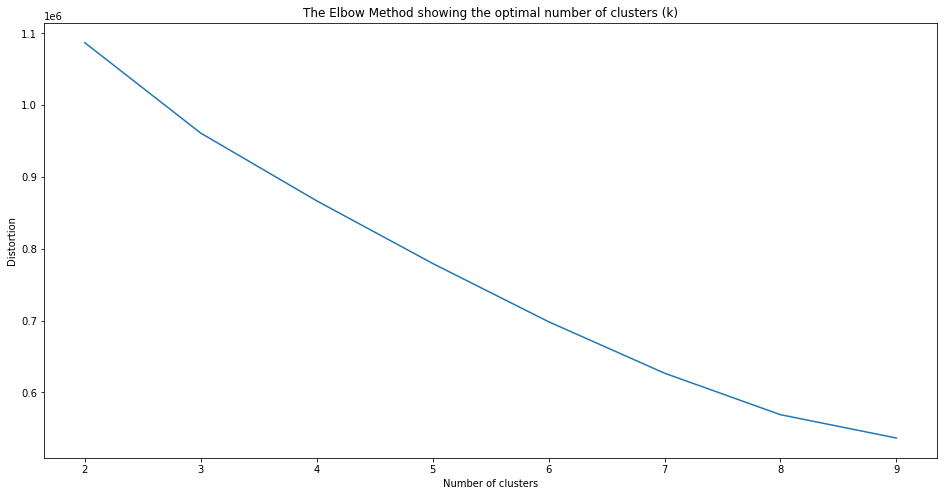

In [91]:
# elbow method
w = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_x2)
    w.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, w)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters (k)')

plt.show()

Steps for Customer segmentation:
1. fit the pca dataframe/numpy array to Kmeans cluster based on best score from elbow method
2. get back the data_small that we have used for scaled_df and pca, and transform it back using oe.inverse_transform
3. transform the fitted KMeans by doing a kmeans.transform
4. create a new column

In [80]:
scaled_df

,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
0,-0.481192,1.424922,-0.839401,-0.356973,-0.258174,-0.375649,2.218826,-0.698989,-0.239754,-0.229514,-1.526639,-0.180619,-2.026279
75559,1.880428,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.438757
75560,-0.481192,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.012110
75561,-0.481192,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.012110
75562,-0.481192,-0.701793,-0.839401,-0.356973,-0.258174,-0.375649,1.425588,-0.642446,-0.239754,-0.229514,0.050813,-0.180619,-0.012110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,-0.481192,1.424922,1.191326,-0.356973,-0.258174,-0.375649,0.035089,1.572175,-0.239754,-0.229514,0.839539,-0.180619,2.082031
40040,0.699618,1.424922,1.191326,-0.356973,3.873352,-0.375649,0.837659,1.562751,-0.239754,-0.229514,0.839539,-0.180619,4.170813
13794,-0.481192,1.424922,1.191326,-0.356973,-0.258174,-0.375649,-0.814141,1.562751,-0.239754,-0.229514,0.839539,-0.180619,2.081435
40038,-0.481192,1.424922,-0.839401,-0.356973,-0.258174,-0.375649,0.809663,-0.322033,-0.239754,-3.706621,0.050813,-0.180619,0.251816


In [81]:
data_small

,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
0,1.0,1.0,False,0.0,False,False,342,0,False,2.0,3.0,0,0.00
75559,3.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,80.00
75560,1.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,101.50
75561,1.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,101.50
75562,1.0,0.0,False,0.0,False,False,257,6,False,2.0,5.0,0,101.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,1.0,1.0,True,0.0,False,False,108,241,False,2.0,6.0,0,207.03
40040,2.0,1.0,True,0.0,True,False,194,240,False,2.0,6.0,0,312.29
13794,1.0,1.0,True,0.0,False,False,17,240,False,2.0,6.0,0,207.00
40038,1.0,1.0,False,0.0,False,False,191,40,False,0.0,5.0,0,114.80


In [82]:
data_small[categorical_cols] = oe.inverse_transform(data_small[categorical_cols])

/var/folders/l9/swvqvt0552gfk3662mhw83b00000gn/T/ipykernel_61270/1336617368.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
data_small

,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr
0,Couple,Resort Hotel,False,weekday,False,False,342,0,False,Transient,Direct,0,0.00
75559,Single,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,80.00
75560,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.50
75561,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.50
75562,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,Couple,Resort Hotel,True,weekday,False,False,108,241,False,Transient,Online TA,0,207.03
40040,Family,Resort Hotel,True,weekday,True,False,194,240,False,Transient,Online TA,0,312.29
13794,Couple,Resort Hotel,True,weekday,False,False,17,240,False,Transient,Online TA,0,207.00
40038,Couple,Resort Hotel,False,weekday,False,False,191,40,False,Contract,Offline TA/TO,0,114.80


In [92]:
clusters = KMeans(n_clusters=8,random_state=15).fit_predict(pca_x2)

In [93]:
data_small['clusters'] = clusters
data_small

/var/folders/l9/swvqvt0552gfk3662mhw83b00000gn/T/ipykernel_61270/4219275197.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,family_type,hotel,special_request,preferred_day,driving,room_change,lead_time,agent,had_cancelations,customer_type,market_segment,is_repeated_guest,adr,clusters
0,Couple,Resort Hotel,False,weekday,False,False,342,0,False,Transient,Direct,0,0.00,2
75559,Single,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,80.00,2
75560,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.50,2
75561,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.50,2
75562,Couple,City Hotel,False,weekday,False,False,257,6,False,Transient,Offline TA/TO,0,101.50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40039,Couple,Resort Hotel,True,weekday,False,False,108,241,False,Transient,Online TA,0,207.03,1
40040,Family,Resort Hotel,True,weekday,True,False,194,240,False,Transient,Online TA,0,312.29,5
13794,Couple,Resort Hotel,True,weekday,False,False,17,240,False,Transient,Online TA,0,207.00,1
40038,Couple,Resort Hotel,False,weekday,False,False,191,40,False,Contract,Offline TA/TO,0,114.80,1


In [97]:
data_small.groupby('clusters').describe()['adr']

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,31548.0,121.773530,49.842430,0.00,92.16,115.63,141.0,5400.00
1,19473.0,107.779509,62.633233,0.00,59.13,89.00,143.0,450.00
2,28792.0,89.262793,34.387871,0.00,65.00,87.30,109.0,341.00
3,3513.0,63.522869,43.650193,-6.38,38.50,65.00,80.0,349.00
4,11008.0,84.405199,45.356554,0.00,51.00,78.80,110.0,310.20
5,6774.0,116.414311,61.681669,0.00,68.44,104.00,154.0,508.00
6,10924.0,104.066850,41.984950,0.00,78.40,96.30,123.0,359.00
7,5781.0,76.397687,27.934438,0.00,62.00,62.80,90.0,276.53


<AxesSubplot:xlabel='family_type', ylabel='clusters'>

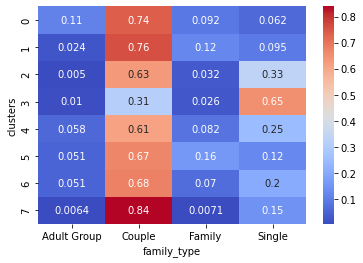

In [95]:
df1 = pd.pivot_table(data_small,index='clusters', columns = ['family_type'], aggfunc='size')
df1.fillna(0, inplace=True)
total = df1.sum(axis=1)
df1['Adult Group'] = df1['Adult Group'] / total
df1['Couple'] = df1['Couple'] / total
df1['Family'] = df1['Family'] / total
df1['Single'] = df1['Single'] / total
sns.heatmap(df1, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='hotel', ylabel='clusters'>

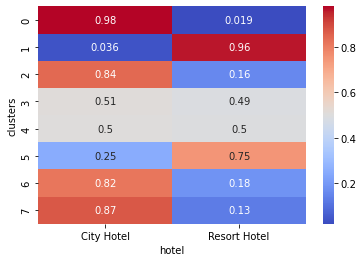

In [96]:
df2 = pd.pivot_table(data_small,index='clusters', columns = ['hotel'], aggfunc='size')
total = df2.sum(axis=1)
df2['City Hotel'] = df2['City Hotel'] / total
df2['Resort Hotel'] = df2['Resort Hotel'] / total
sns.heatmap(df2, annot=True, cmap='coolwarm')